In [1]:
import polars as pl
import matplotlib.pyplot as plt
import blitzbeaver as bb

In [5]:
csv_path = "../../aptihramy/data/csv_cleaned"

start_year = 1835
end_year = 1850

dataframes = [
    pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    for year in range(start_year, end_year + 1)
]

In [6]:
for i in range(len(dataframes)):
    df = dataframes[i]
    dataframes[i] = df.with_columns(df["enfants_chez_parents_prenom"].str.split("|")
                                    .list.eval(pl.element().filter(pl.element() != ""))
                                    .alias("enfants_chez_parents_prenom"))

In [2]:
# load the graph from a .beaver file
path_graph = "../graph.beaver"

graph = bb.read_beaver(path_graph)

In [3]:
record_schema = bb.RecordSchema(
    [
        bb.FieldSchema("nom_rue", bb.ElementType.String),
        bb.FieldSchema("chef_prenom", bb.ElementType.String),
        bb.FieldSchema("chef_nom", bb.ElementType.String),
        bb.FieldSchema("chef_origine", bb.ElementType.String),
        bb.FieldSchema("epouse_nom", bb.ElementType.String),
        bb.FieldSchema("chef_vocation", bb.ElementType.String),
        bb.FieldSchema("enfants_chez_parents_prenom", bb.ElementType.MultiStrings),
    ]
)

In [4]:
distance_metric_config = bb.DistanceMetricConfig(
    metric="lv_opti",
    caching_threshold=4,
    use_sigmoid=False,
    lv_substring_weight=0.5,
)
normal_memory_config = bb.MemoryConfig(
    memory_strategy="median",
)
multi_memory_config = bb.MemoryConfig(
    memory_strategy="mw-median",
    multiword_threshold_match=0.6,
    multiword_distance_metric=distance_metric_config,
)

config = bb.config(
    record_schema=record_schema,
    distance_metric_config=distance_metric_config,
    record_scorer_config=bb.RecordScorerConfig(
        record_scorer="weighted-average",
        weights=[
            0.15,
            0.25,
            0.25,
            0.1,
            0.1,
            0.1,
            0.1,
        ],
        min_weight_ratio=0.7,
    ),
    resolver_config=bb.ResolverConfig(
        resolving_strategy="best-match",
    ),
    memory_config=normal_memory_config,
    multistring_memory_config=multi_memory_config,
    interest_threshold=0.6,
    limit_no_match_streak=3,
    num_threads=17,
)

In [29]:
# compute the graph
graph = bb.execute_tracking(config, record_schema, dataframes, "debug")

[DEBUG]: processing frame 1...
[DEBUG]: [worker 12] process frame 1:  trackers: 246  cache size: 161642
[DEBUG]: [worker 2] process frame 1:  trackers: 255  cache size: 181037
[DEBUG]: [worker 6] process frame 1:  trackers: 246  cache size: 153942
[DEBUG]: [worker 9] process frame 1:  trackers: 246  cache size: 138027
[DEBUG]: [worker 4] process frame 1:  trackers: 246  cache size: 170228
[DEBUG]: [worker 7] process frame 1:  trackers: 246  cache size: 149467
[DEBUG]: [worker 8] process frame 1:  trackers: 246  cache size: 150043
[DEBUG]: [worker 11] process frame 1:  trackers: 246  cache size: 156683
[DEBUG]: [worker 10] process frame 1:  trackers: 246  cache size: 158555
[DEBUG]: [worker 15] process frame 1:  trackers: 246  cache size: 173601
[DEBUG]: [worker 5] process frame 1:  trackers: 246  cache size: 167677
[DEBUG]: [worker 3] process frame 1:  trackers: 246  cache size: 165975
[DEBUG]: [worker 14] process frame 1:  trackers: 246  cache size: 166450
[DEBUG]: [worker 13] process

In [30]:
def aggregate_histograms(histograms: list[int]) -> list[int]:
    """
    Aggregates a list of histograms into a single histogram.
    """
    max_len = max([len(h) for h in histograms])
    result = [0] * max_len
    for h in histograms:
        for i, v in enumerate(h):
            result[i] += v
    return result

def summary_graph(graph: bb.TrackingGraph):
    # compute the sum of the histograms for all frames
    histogram_records = aggregate_histograms([resolving.histogram_record_matchs for resolving in graph.diagnostics.resolvings])
    # do not show beyond 10 elements as the counts are very low
    histogram_records = histogram_records
    histogram_trackers = aggregate_histograms([resolving.histogram_tracker_matchs for resolving in graph.diagnostics.resolvings])
    histogram_trackers = histogram_trackers[:10]

    chain_metrics = bb.evaluate_tracking_chain_length(graph._raw)
    graph_metrics = bb.evaluate_tracking_graph_properties(graph._raw)

    records_match_ratios = graph_metrics.records_match_ratios[1:]
    trackers_match_ratios = graph_metrics.trackers_match_ratios[1:-1]
    avg_records_match = sum(records_match_ratios) / len(records_match_ratios)
    avg_trackers_match = sum(trackers_match_ratios) / len(trackers_match_ratios)

    per_divergence = sum(histogram_trackers[2:]) / sum(histogram_trackers[1:])
    per_conflict = sum(histogram_records[2:]) / sum(histogram_records[1:])

    # total number of trackers created
    print(f"Number of chains: {len(graph.trackers_ids)}")
    # average percentage of records that have been match with an existing tracker
    print(f"Percentage of matching records: {avg_records_match*100:.2f}%")
    # average percentage of trackers that have match with a record of the current frame
    print(f"Percentage of matching trackers: {avg_trackers_match*100:.2f}%")
    # number of times a tracker matched with more that one record
    # divided by the number of times a tracker matched with a record
    print(f"Percentage of divergences: {per_divergence*100:.2f}%")
    # number of times a record matched with multiple trackers
    # divided by the number of times a record matched with a tracker
    print(f"Percentage of conflicts: {per_conflict*100:.2f}%")

    plt.bar(range(1, len(chain_metrics.histogram)), chain_metrics.histogram[1:])
    plt.title("Histogram of tracking chain lengths")
    plt.show()

    plt.bar(range(len(histogram_records)), histogram_records)
    plt.title("Histogram of # matchs per record")
    plt.show()

    plt.bar(range(len(histogram_trackers)), histogram_trackers)
    plt.title("Histogram of # matchs per tracker")
    plt.show()

    

Number of chains: 20651
Percentage of matching records: 72.94%
Percentage of matching trackers: 84.37%
Percentage of divergences: 22.67%
Percentage of conflicts: 34.69%


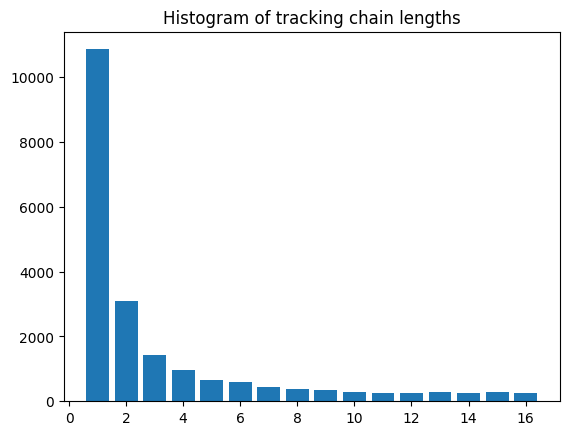

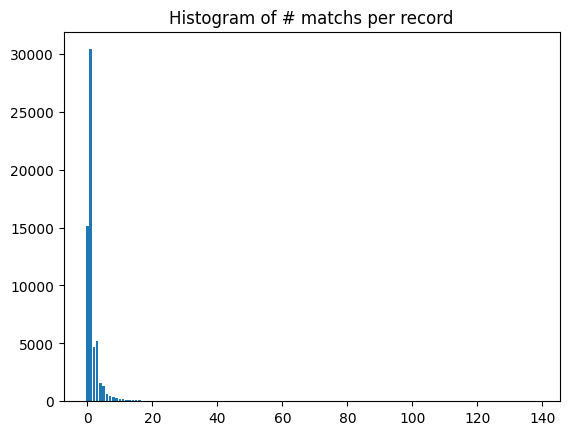

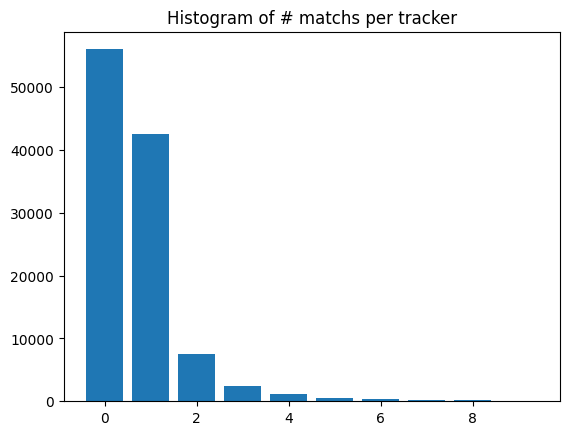

In [31]:
summary_graph(graph)

In [32]:
path_graph = "../graph.beaver"

bb.save_beaver(path_graph, graph)

In [7]:
def find_chain_with_length(graph: bb.TrackingGraph, start_idx: int, length: int) -> None:
    idx = start_idx
    while idx < len(graph.trackers_ids):
        tracker_id = graph.trackers_ids[idx]
        chain = graph._raw.get_tracking_chain(tracker_id)
        if len(chain) >= length:
            return tracker_id
        idx += 1
    return None

In [8]:
# chain = find_chain_with_length(graph, dataframes, record_schema, 0, 3)
tracker_id = find_chain_with_length(graph, 0, 15)
chain = graph.materialize_tracking_chain(tracker_id, dataframes, record_schema)
chain.as_dataframe()

frame_idx,nom_rue,chef_prenom,chef_nom,chef_origine,epouse_nom,chef_vocation,enfants_chez_parents_prenom
i64,str,str,str,str,str,str,list[str]
0,"""st jean""","""jacob""","""liber""","""jongny""","""ansermel""",null,"[""emmanuel""]"
1,"""jean""","""jacob""","""siber""","""jongny""","""ansermet""","""graveur""","[""henri"", ""emanuel""]"
2,"""ps jean""","""jacob""","""siber""","""jongny""","""ansermet""","""graveur""","[""henri"", ""emanuel"", ""rosalier""]"
3,"""petit fjean""","""jacob""","""siber""","""jongny|minnoid""","""ansente""","""graveur""","[""henri"", ""emanuel"", ""rovalie""]"
4,"""lit fsan""","""jacob""","""siber""","""fongny""","""andermet""","""graveur""","[""henri"", ""emanuel"", ""emanuel""]"
…,…,…,…,…,…,…,…
10,"""bourg""","""jacob""","""sieber""","""jougny""","""genwyller""","""eveur""","[""henri"", ""emanuel"", ""louise""]"
11,"""ane de bourg""","""jacob""","""sieber""","""jingny""","""greyller""","""praveur""","[""henri"", ""emmaule"", ""louise""]"
12,"""bourg""","""jacob .""","""eiber""","""jongny""","""guenyler""","""lingere""","[""henri"", ""emanuel"", ""oude""]"


In [9]:
df = chain.as_dataframe()

In [13]:
def get_col_as_list(df: pl.DataFrame, col: str) -> list[str]:
    return [v for v in df[col] if v is not None]

In [15]:
words = [
    "magimelien",
    "mazimilien",
    "mazirelien",
    "marinelien",
    "bob",
    "boob",
]
bb.compute_median_word(words)


'mazimelien'

In [22]:
r = bb.compute_words_clusters(
    get_col_as_list(df, "epouse_nom"),
    distance_metric_config,
    threshold_match=0.6,
)

0.00 0.88 0.88 0.62 0.75 0.88 0.88 0.88 0.11 0.22 0.12 0.12 0.11 0.11 
0.88 0.00 1.00 0.62 0.88 1.00 1.00 1.00 0.11 0.22 0.12 0.12 0.11 0.11 
0.88 1.00 0.00 0.62 0.88 1.00 1.00 1.00 0.11 0.22 0.12 0.12 0.11 0.11 
0.62 0.62 0.62 0.00 0.50 0.62 0.62 0.62 0.11 0.22 0.12 0.12 0.11 0.11 
0.75 0.88 0.88 0.50 0.00 0.88 0.88 0.88 0.11 0.22 0.12 0.12 0.11 0.11 
0.88 1.00 1.00 0.62 0.88 0.00 1.00 1.00 0.11 0.22 0.12 0.12 0.11 0.11 
0.88 1.00 1.00 0.62 0.88 1.00 0.00 1.00 0.11 0.22 0.12 0.12 0.11 0.11 
0.88 1.00 1.00 0.62 0.88 1.00 1.00 0.00 0.11 0.22 0.12 0.12 0.11 0.11 
0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.00 0.78 0.78 0.78 1.00 1.00 
0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.78 0.00 0.67 0.56 0.78 0.78 
0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.78 0.67 0.00 0.62 0.78 0.78 
0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.78 0.56 0.62 0.00 0.78 0.78 
0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 1.00 0.78 0.78 0.78 0.00 1.00 
0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 1.00 0.78 0.78 0.78 1.00 0.00 
0.00 0

In [23]:
r

[['ansermel',
  'ansermet',
  'ansermet',
  'ansente',
  'andermet',
  'ansermet',
  'ansermet',
  'ansermet'],
 ['guewyller', 'genwyller', 'greyller', 'guenyler', 'guewyller', 'guewyller']]